# Simulation example using Area Yield DGP

In [1]:
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor, LGBMClassifier
from rdrobust import rdrobust

import doubleml as dml
from doubleml.rdd import RDFlex
from doubleml.rdd import datasets

from matplotlib import pyplot as plt
from statsmodels.nonparametric.kernel_regression import KernelReg

import plotly.express as px

In [2]:
%run utils.py

## DGP Parameters

In [3]:
params = dict(
    seed=17,
    n_obs=3,
    K=500,
    # origin
    origin_shape='ellipsis',
    origin_a=0.035,
    origin_b=0.01,
    origin_pertubation=0.1,
    # target
    target_center=[1.5, 0],
    target_a=0.6,
    target_b=0.3,
    # action
    action_shift=[1.0, 0],
    action_scale=1.02,
    #action_pertubation=None,
    action_pertubation=[0.001, 0.0006],
    action_drag_share=0.7,
    action_drag_scale=0.5,
    # running
    running_dist_measure='projected',
    running_mea_selection=5,
    # treatment
    treatment_dist=0.45,
    treatment_improvement=0,
    treatment_random_share=0.001,
)

## DGP Visualization

In [4]:

data = datasets.dgp_area_yield(**params)

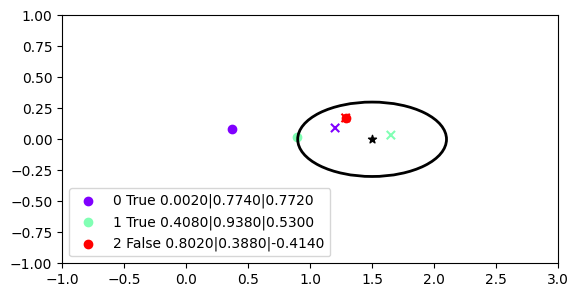

In [5]:

plot_mean_shift(data, params, legend=True)

- Untreated state are the dots
- Treated staes are the crosses
- Red lot was not reworked compared to the other lots
- Target area is indicated by the black ellipse

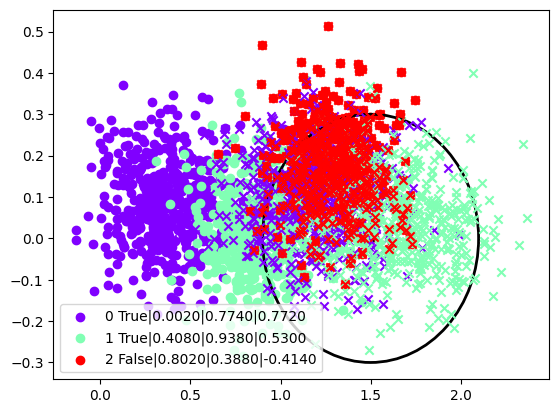

In [6]:
# plot of the individual items of the lots
plot_shift(data, params, legend=True)

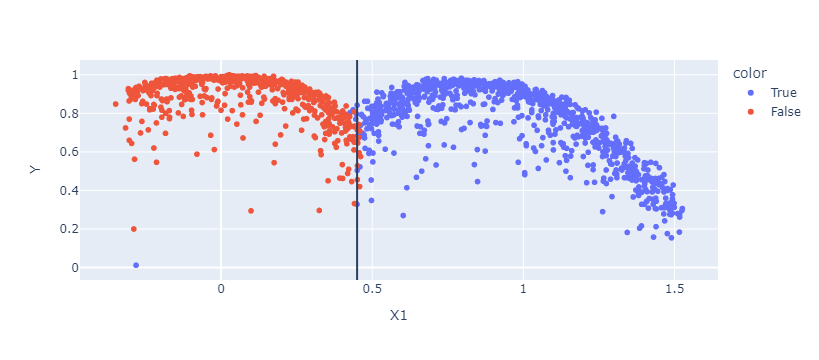

In [11]:
data = datasets.dgp_area_yield(**{**params, 'n_obs': 1500})

fig = px.scatter(x=data['X1'] ,y=data['Y'], color=data['D'], labels=dict(x="X1", y="Y"), hover_data={'X2': data['X2'], 'X1_act': data['X1_act'], 'X2_act': data['X2_act']}) 
fig.add_vline(x=params['treatment_dist'])

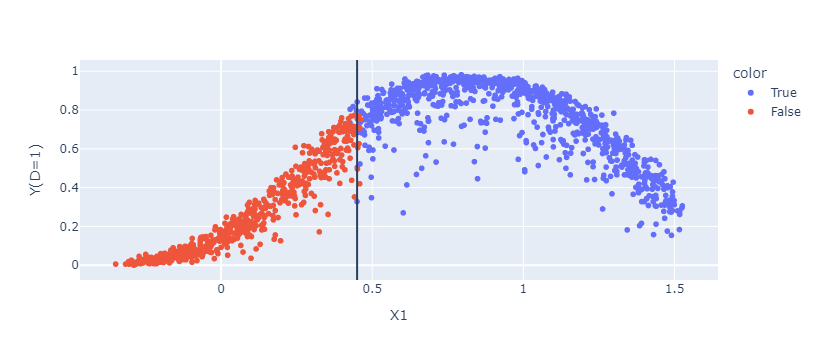

In [13]:
fig = px.scatter(x=data['X1'] ,y=data['Y1'], color=data['D'], labels=dict(x="X1", y="Y(D=1)"), hover_data={'X2': data['X2'], 'X1_act': data['X1_act'], 'X2_act': data['X2_act']}) 
fig.add_vline(x=params['treatment_dist'])

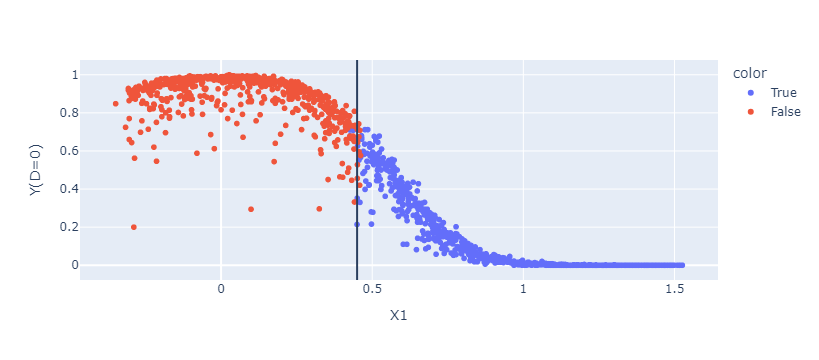

In [14]:
fig = px.scatter(x=data['X1'] ,y=data['Y0'], color=data['D'], labels=dict(x="X1", y="Y(D=0)"), hover_data={'X2': data['X2'], 'X1_act': data['X1_act'], 'X2_act': data['X2_act']}) 
fig.add_vline(x=params['treatment_dist'])

## Oracle / Neighborhood Estimator
Estimation is done using bigger sample

In [7]:
n_obs = 1000
selected_params = {**params, 'n_obs': n_obs}
data = datasets.dgp_area_yield(**selected_params)

In [8]:
score = data["X1"]
ite = data['Y1'] - data['Y0']

# TODO drop defiers when estimating with kernelreg
kernel_reg = KernelReg(endog=ite, exog=score, var_type='c', reg_type='ll')

In [9]:
cutoff = params['treatment_dist']
score_grid = np.linspace(score.min(), score.max(), 1000)
predicted_grid, _ = kernel_reg.fit(score_grid)

effect_at_cutoff, _  = kernel_reg.fit(np.array([cutoff]))
print(f"Estimated effect at cutoff: {effect_at_cutoff[0]}")

Estimated effect at cutoff: 0.04143889133246857


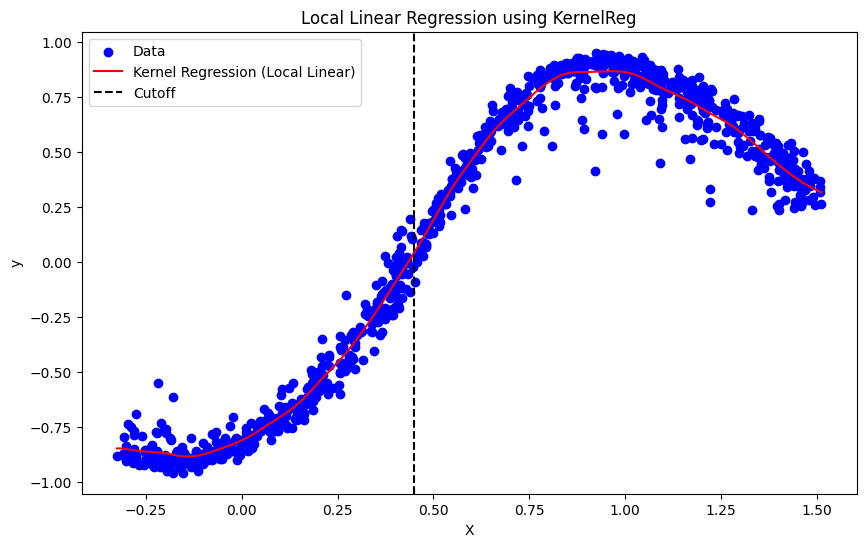

In [10]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(score, ite, color='blue', label='Data')
plt.plot(score_grid, predicted_grid, color='red', label='Kernel Regression (Local Linear)')
plt.xlabel('X')
plt.ylabel('y')
# add vertical line at cutoff
plt.axvline(x=cutoff, color='black', linestyle='--', label='Cutoff')
plt.legend()
plt.title('Local Linear Regression using KernelReg')
plt.show()


In [11]:
treatment_dist = params['treatment_dist']
X1_close = (data["X1"] > treatment_dist - 0.02) & (data["X1"] < treatment_dist + 0.02)
print(f'Neighborhood observations: {X1_close.sum()}')
print(f'Neighborhood estimator: {data["Y1"][X1_close].mean() - data["Y0"][X1_close].mean()}')
print(f"Local Kernel Regression Estimator: {effect_at_cutoff[0]}")

Neighborhood observations: 16
Neighborhood estimator: 0.030625000000000013
Local Kernel Regression Estimator: 0.04143889133246857


In [14]:
res_list = []
for r in range(20):
    n_obs = 2000
    selected_params = {**params, 'n_obs': n_obs, 'seed': r}
    data = datasets.dgp_area_yield(**selected_params)
    
    score = data["X1"]
    ite = data['Y1'] - data['Y0']

    kernel_reg = KernelReg(endog=ite, exog=score, var_type='c', reg_type='ll')
    cutoff = params['treatment_dist']

    effect_at_cutoff, _  = kernel_reg.fit(np.array([cutoff]))
    X1_close = (data["X1"] > treatment_dist - 0.02) & (data["X1"] < treatment_dist + 0.02)
    neighbor_est = data["Y1"][X1_close].mean() - data["Y0"][X1_close].mean()

    Y = data["Y"]
    Z = data["Z"].reshape(n_obs, -1)
    D = data["D"]

    res = rdrobust(y=Y, x=score, fuzzy=D, covs=Z, c=cutoff)
    res_list.append({"rep": "r", "method": "linear", "orcl": effect_at_cutoff[0], "orcl_neigh": neighbor_est,
                     "coef": res.coef.loc["Conventional", "Coeff"], "se": res.se.loc["Robust", "Std. Err."], 
                     "2.5 %": res.ci.loc["Robust", "CI Lower"], "97.5 %": res.ci.loc["Robust", "CI Upper"]})
    
    ml_g = LGBMRegressor(n_estimators=100, learning_rate=0.01, verbose=-1, n_jobs=-1)
    ml_m = LGBMClassifier(n_estimators=100, learning_rate=0.01, verbose=-1, n_jobs=-1)

    dml_data = dml.DoubleMLData.from_arrays(y=Y, d=D, x=Z, s=score)
    rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      n_folds=5,
                      n_rep=1,
                      cutoff=cutoff,
                      fuzzy=True)
    rdflex_model.fit(n_iterations=2)
    res_list.append({"rep": "r", "method": "lgbm new b=1", "orcl": effect_at_cutoff[0], "orcl_neigh": neighbor_est,
                     "coef": rdflex_model.coef[0], "se": rdflex_model.se[2], 
                     "2.5 %": rdflex_model.confint().loc["Robust", "2.5 %"], "97.5 %": rdflex_model.confint().loc["Robust", "97.5 %"]})
    
    rdflex_model = RDFlex(dml_data,
                      ml_g,
                      ml_m,
                      n_folds=5,
                      n_rep=3,
                      cutoff=cutoff,
                      fuzzy=True)
    rdflex_model.fit(n_iterations=2)
    res_list.append({"rep": "r", "method": "lgbm new b=3", "orcl": effect_at_cutoff[0], "orcl_neigh": neighbor_est,
                     "coef": rdflex_model.coef[0], "se": rdflex_model.se[2], 
                     "2.5 %": rdflex_model.confint().loc["Robust", "2.5 %"], "97.5 %": rdflex_model.confint().loc["Robust", "97.5 %"]})

In [15]:
df = pd.DataFrame(res_list)

In [16]:
df["CI width"] = df["97.5 %"] - df["2.5 %"]
df["stand. coef"] = (df["coef"] - df["orcl"]) / df["se"]
df["coverage"] = ((df["2.5 %"] < df["orcl"]) & (df["97.5 %"] > df["orcl"]))

In [17]:
df.groupby("method")["coverage"].mean()

method
lgbm new b=1    0.80
lgbm new b=3    0.85
linear          0.30
Name: coverage, dtype: float64

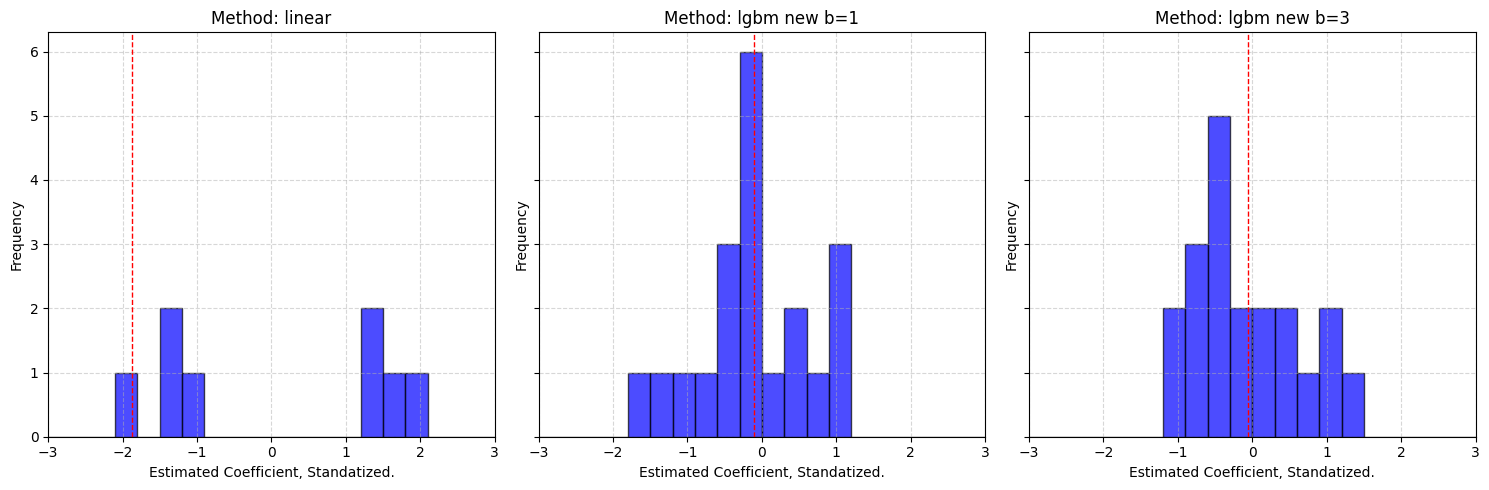

In [18]:
unique_methods = df['method'].unique()

# Anzahl der Methoden (um die Subplots korrekt anzulegen)
n_methods = len(unique_methods)

# Setze die Größe der Gesamtfigur an. Anpassen, falls nötig.
fig, axes = plt.subplots(1, n_methods, figsize=(15, 5), sharey=True)

# Erstelle für jede Methode ein Subplot
for i, method in enumerate(unique_methods):
    ax = axes[i] if n_methods > 1 else axes
    subset = df[df['method'] == method]
    
    # Zeichne das Histogramm
    ax.hist(subset['stand. coef'], bins=20, range=(-3,3), alpha=0.7, color='blue', edgecolor='black')
    
    # Mean CI Width und vertikale Linie dafür
    mean_ci_width = subset['stand. coef'].mean()
    ax.axvline(mean_ci_width, color='red', linestyle='dashed', linewidth=1)
    
    # Achsentitel und Limiten
    ax.set_title(f'Method: {method}')
    ax.set_xlim(-3,3)
    ax.set_xlabel('Estimated Coefficient, Standatized.')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

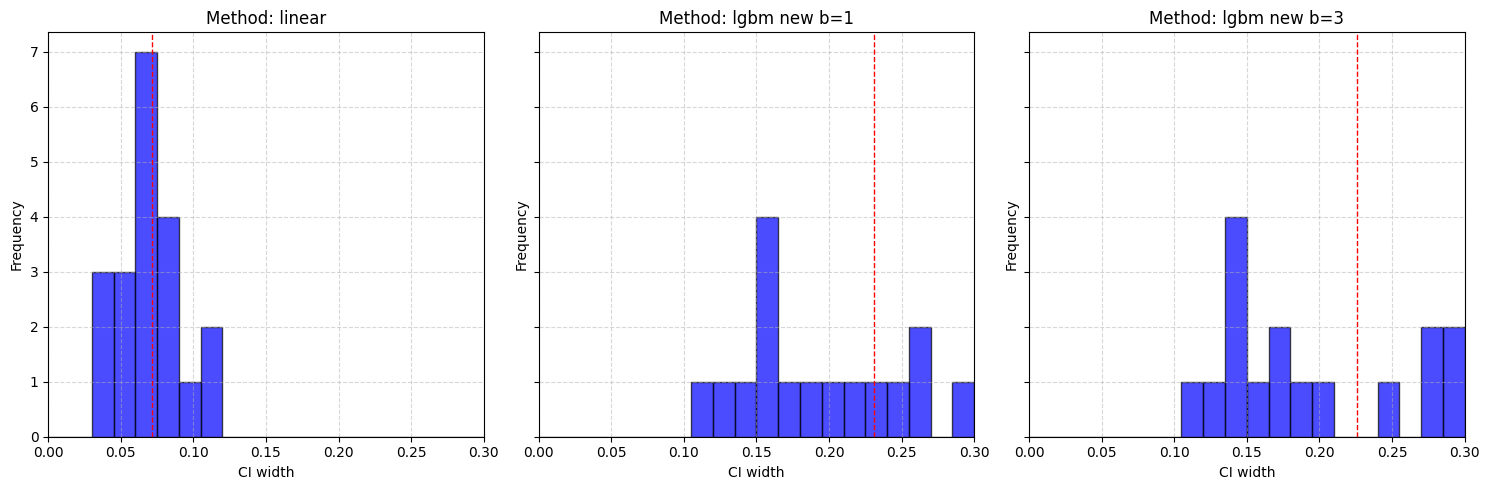

In [19]:
unique_methods = df['method'].unique()

# Anzahl der Methoden (um die Subplots korrekt anzulegen)
n_methods = len(unique_methods)

# Setze die Größe der Gesamtfigur an. Anpassen, falls nötig.
fig, axes = plt.subplots(1, n_methods, figsize=(15, 5), sharey=True)

# Erstelle für jede Methode ein Subplot
for i, method in enumerate(unique_methods):
    ax = axes[i] if n_methods > 1 else axes
    subset = df[df['method'] == method]
    
    # Zeichne das Histogramm
    ax.hist(subset['CI width'], bins=20, range=(0, 0.3), alpha=0.7, color='blue', edgecolor='black')
    
    # Mean CI Width und vertikale Linie dafür
    mean_ci_width = subset['CI width'].mean()
    ax.axvline(mean_ci_width, color='red', linestyle='dashed', linewidth=1)
    
    # Achsentitel und Limiten
    ax.set_title(f'Method: {method}')
    ax.set_xlim(0, 0.3)
    ax.set_xlabel('CI width')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [76]:
df.to_csv("res/results_area_yield.csv")